In [1]:
from src.rejax.envs.bernoulli_bandit import BernoulliBandit, EnvParams
from rejax import get_algo
from rejax.evaluate import evaluate

import _pickle as pickle
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [2]:
config_path = "/Users/chanb/research/ualberta/sandbox/rejax/configs/custom/bandit.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f.read())

In [3]:
algo_name = "ucb"
seed_id = 42
num_seeds = 10
num_arms = 5

key = jax.random.PRNGKey(seed_id)
keys = jax.random.split(key, num_seeds)
config = config[algo_name]

In [4]:
config

{'agent_kwargs': {'confidence': 1.0},
 'total_timesteps': 10000,
 'eval_freq': 50,
 'buffer_size': 10000}

In [5]:
env = BernoulliBandit()
config["env"] = env

env_params = jax.random.beta(key, a=0.2, b=0.2, shape=(num_seeds, num_arms))

algo_cls = get_algo(algo_name)
algo = jax.vmap(
    lambda x: algo_cls.create(
        **config,
        env_params=EnvParams(reward_probs=x),
    )
)(
    env_params
)


def eval_callback(algo, ts, rng):
    act = algo.make_act(ts)
    max_steps = algo.env_params.max_steps_in_episode
    return evaluate(act, rng, env, algo.env_params, 200, max_steps)

algo = algo.replace(
    eval_callback=eval_callback
)

In [6]:
algo.env_params.reward_probs

Array([[9.8228019e-01, 9.9999964e-01, 8.2774550e-01, 8.4435036e-03,
        9.0748203e-01],
       [3.3898753e-01, 4.3795776e-01, 5.6661258e-05, 1.4348644e-03,
        3.3623093e-01],
       [9.9965811e-01, 9.3900967e-01, 3.0559276e-03, 4.0207192e-02,
        1.8510675e-02],
       [8.9926082e-01, 2.4732055e-02, 9.9872202e-01, 7.5815129e-01,
        2.2199431e-04],
       [8.9778149e-01, 8.5924696e-03, 9.9802184e-01, 9.7188449e-01,
        2.8876496e-02],
       [1.3429711e-03, 1.7345850e-01, 2.4964206e-04, 9.5043749e-01,
        6.4668870e-01],
       [9.8190892e-01, 9.9999702e-01, 6.8048167e-01, 4.1367918e-01,
        1.0990708e-05],
       [7.4822354e-01, 1.0000000e+00, 9.9977964e-01, 6.1963946e-01,
        4.7781399e-01],
       [1.2988218e-02, 1.5381564e-01, 4.9959421e-01, 3.8145515e-01,
        9.8737073e-01],
       [9.5657980e-01, 9.3993150e-02, 2.2493351e-04, 9.9955672e-01,
        2.1557730e-01]], dtype=float32)

In [7]:
vmap_train = jax.jit(jax.vmap(algo_cls.train, in_axes=(0, 0)))
ts, (_, returns) = vmap_train(algo, keys)
returns.block_until_ready()

print(None)

/Users/chanb/research/ualberta/sandbox/rejax/.venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


None


In [8]:
jax.vmap(lambda x: jax.numpy.mean(x, axis=-1)[-1])(returns)

Array([1.        , 0.47      , 1.        , 0.995     , 0.98999995,
       0.955     , 1.        , 1.        , 0.995     , 1.        ],      dtype=float32)

In [9]:
np.argmax(env_params, axis=-1)

Array([1, 1, 0, 2, 2, 3, 1, 1, 4, 3], dtype=int32)

In [10]:
np.argmax(ts.agent_ts.params["params"]["counts"], axis=-1).T

Array([[1, 1, 0, 2, 2, 3, 1, 1, 4, 3]], dtype=int32)

In [11]:
np.argmax(ts.agent_ts.params["params"]["q_values"], axis=-1).T

Array([[1, 1, 0, 2, 2, 3, 1, 1, 4, 3]], dtype=int32)

In [12]:
jax.debug.print("{x}", x=ts.agent_ts.params)

{'params': {'counts': Array([[[3188., 5757.,  273.,   17.,  765.]],

       [[ 788., 8222.,   77.,   81.,  832.]],

       [[8334., 1613.,   17.,   19.,   17.]],

       [[ 865.,   21., 8786.,  311.,   17.]],

       [[ 901.,   19., 6601., 2462.,   17.]],

       [[  19.,   27.,   19., 9755.,  180.]],

       [[3759., 6051.,  138.,   35.,   17.]],

       [[ 115., 4840., 4840.,  149.,   56.]],

       [[  18.,   32.,   61.,   42., 9847.]],

       [[2253.,   17.,   17., 7687.,   26.]]], dtype=float32), 'q_values': Array([[[0.9805517 , 1.        , 0.7948715 , 0.        , 0.9006534 ]],

       [[0.33629432, 0.44234985, 0.        , 0.01234568, 0.3401443 ]],

       [[0.9996283 , 0.93924385, 0.        , 0.05263158, 0.        ]],

       [[0.89826626, 0.0952381 , 0.99884623, 0.8006432 , 0.        ]],

       [[0.9067702 , 0.05263158, 0.9975679 , 0.96385044, 0.        ]],

       [[0.        , 0.14814813, 0.        , 0.9469013 , 0.66666657]],

       [[0.9851023 , 1.        , 0.6884058 , 0.3

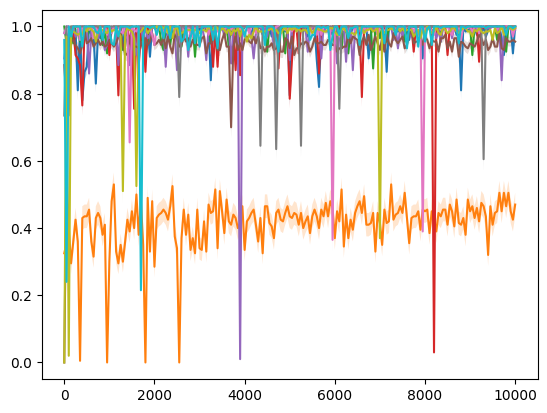

In [13]:
for env_returns in returns:
    xrange = np.arange(len(env_returns)) * config["eval_freq"]
    mean = np.mean(env_returns, axis=-1)
    std = np.std(env_returns, axis=-1) / np.sqrt(env_returns.shape[-1])
    plt.plot(xrange, mean)
    plt.fill_between(xrange, mean - std, mean + std, alpha=0.2)
plt.show()


In [14]:
pickle.dump(
    ts.store_buffer.__dict__,
    open("learning_hist-{}.dill".format(algo_name), "wb"),
)